In [76]:
import numpy as np
import pandas as pd
import requests as rq
import matplotlib.pyplot as plt

from prophet import Prophet
from xgboost import XGBRegressor
import matplotlib.dates as mdates
from bs4 import BeautifulSoup as bs
from datetime import timedelta, date
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### ATUALIZAÇÃO DE DADOS


In [77]:
headers = {
    'User-Agent': 'Mozilla/5.0',
    'X-Requested-With': 'XMLHttpRequest',
    'Content-Type': 'application/x-www-form-urlencoded'
}


url = 'https://br.investing.com/indices/bovespa-historical-data'
response = rq.get(url, headers=headers)

soup = bs(response.content)
tabela = soup.find('table')


actual_df = pd.read_html(str(tabela), parse_dates=['Data'], index_col='Data')[0].drop_duplicates()

today = date.today()
actual_df = actual_df.query('index < @today')
actual_df['Var%'] = actual_df['Var%'] .str.replace('+', '')

C:\Users\dhlui\AppData\Local\Temp\ipykernel_920\3350626653.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  actual_df = pd.read_html(str(tabela), parse_dates=['Data'], index_col='Data')[0].drop_duplicates()
C:\Users\dhlui\AppData\Local\Temp\ipykernel_920\3350626653.py:15: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  actual_df = pd.read_html(str(tabela), parse_dates=['Data'], index_col='Data')[0].drop_duplicates()


### TRATAMENTOS INICIAIS

In [78]:
historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')
historic_df = pd.concat([historic_df, actual_df])

historic_df = historic_df[~historic_df.index.duplicated(keep='last')]

historic_df = historic_df.sort_index()

historic_df.to_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv')

historic_df = historic_df.sort_index()

historic_df['Var%'] = historic_df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

historic_df['Vol.'] = historic_df['Vol.'].str.replace(',', '.')

historic_df['Vol.'] = historic_df['Vol.'].apply(
    lambda x: float(str(x)[:-1].replace(',', '.'))/1_000  if str(x)[-1] == 'K'
    else float(str(x)[:-1].replace(',', '.')) if str(x)[-1] == 'M'
    else float(str(x)[:-1].replace(',', '.')) * 1_000 if str(x)[-1] == 'B'
    else float(str(x).replace(',', '.'))/1_000_000 )

historic_df.rename(columns={'Vol.':'Vol (M)'}, inplace=True)

### CRIANDO BASE DE TREINO E TESTE

C:\Users\dhlui\AppData\Local\Temp\ipykernel_920\3061036111.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)
C:\Users\dhlui\AppData\Local\Temp\ipykernel_920\3061036111.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)
C:\Users\dhlui\AppData\Local\Temp\ipykernel_920\3061036111.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

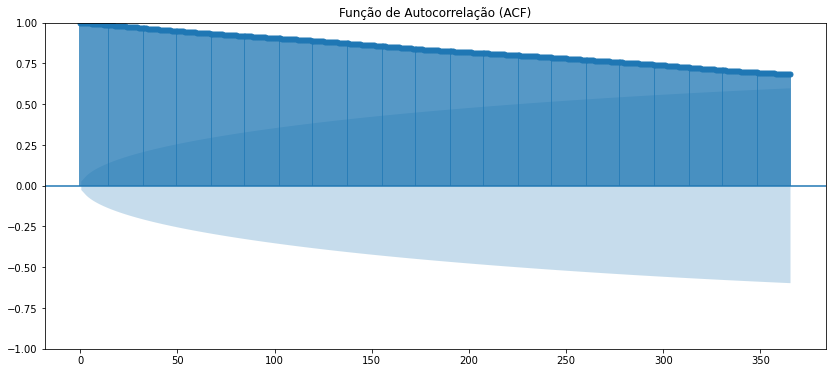

In [79]:
historic_df['day'] = historic_df.index.day
historic_df['week_of_year'] = [dt.weekofyear for dt in historic_df.index]
historic_df['month'] = historic_df.index.month
historic_df['year'] = historic_df.index.year


# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plot_acf(historic_df['Último'].dropna(), ax=plt.gca(), lags=365)
plt.title('Função de Autocorrelação (ACF)')


# Define training and test sets
n_lags = 365
for lag in range(1, n_lags + 1):
    historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)


# Rolling statistics
historic_df[f'rolling_mean_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).mean().shift(1)
historic_df[f'rolling_std_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).std().shift(1)

# Exponential Moving Averages (EMA)
historic_df[f'ema_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).mean().shift(1)
historic_df[f'ema_std_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).std().shift(1)


predictors = [
    'day',
    'week_of_year',
    'month',
    'year',
    *['lag_{}'.format(i) for i in range(1, n_lags + 1)],
    'rolling_mean_{n_lags}'.format(n_lags=n_lags),
    'rolling_std_{n_lags}'.format(n_lags=n_lags),
    'ema_{n_lags}'.format(n_lags=n_lags),
    'ema_std_{n_lags}'.format(n_lags=n_lags),
]


train_end = (date.today()-timedelta(7)).strftime('%Y-%m-%d')

df_train = historic_df.loc[:train_end]
df_test = historic_df.loc[train_end:]

### CRIANDO O RANDOM FOREST PREDICT

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Remover nulos após defasagens
df_train_rf = df_train.dropna()
X_train_rf = df_train_rf[predictors]
y_train_rf = df_train_rf['Último']

df_test_rf = df_test.dropna()
X_test_rf = df_test_rf[predictors]
y_test_rf = df_test_rf['Último'].loc[X_test_rf.index]

# Modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)


rf_model.fit(X_train_rf, y_train_rf)
rf_pred = rf_model.predict(X_test_rf)


rf_pred_series = pd.Series(rf_pred, index=df_test.index, name='pred')
rf_pred_df = rf_pred_series.astype('float64')

mae_rf = mean_absolute_error(df_test['Último'], rf_pred)
rmse_rf = mean_squared_error(df_test['Último'], rf_pred)
mape_rf = 100 * mean_absolute_percentage_error(df_test['Último'], rf_pred)


resultados = pd.DataFrame(
    {
        'Modelo': ['Random Forest'],
        'MAE': [mae_rf],
        'RMSE': [rmse_rf],
        'MAPE (%)': [mape_rf],
        'Accuracy (%)': [
            100 - mape for mape in [mape_rf]
        ],
    }
)

print(resultados)


predictions = np.array([tree.predict(X_test_rf) for tree in rf_model.estimators_])

# Média das previsões (previsão final)
rf_pred = predictions.mean(axis=0)
std_dev = predictions.std(axis=0)
lower_bound = rf_pred - 1.96 * std_dev  # Intervalo inferior
upper_bound = rf_pred + 1.96 * std_dev  # Intervalo superior

rf_intervalo = pd.DataFrame({
    'pred': rf_pred,
    'lower': lower_bound,
    'upper': upper_bound
}, index=df_test.index)

          Modelo       MAE      RMSE  MAPE (%)  Accuracy (%)
0  Random Forest  1.325236  2.983618  1.021655     98.978345


c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature nam

### PREDIÇÃO DOS PRÓXIMOS 3 DIAS

In [83]:
historic_pred_df = historic_df.copy()

historic_pred_df.drop(columns=['Abertura','Máxima','Mínima','Vol (M)','Var%'], axis=1, inplace=True)

index_pred = [today + timedelta(days=i) for i in range(3)]
index_pred = [pd.to_datetime(date) for date in index_pred]

df_pred = pd.DataFrame(columns=[predictors], index=index_pred)


df_pred['day'] = df_pred.index.day
df_pred['week_of_year'] = df_pred.index.isocalendar().week 
df_pred['month'] = df_pred.index.month 
df_pred['year'] = df_pred.index.year


predictions_final = []

for step in range(3):
    data_pred = pd.to_datetime(today + timedelta(days=step))

    for lag in range(1, 41):
        df_pred.loc[data_pred, f'lag_{lag}'] = historic_pred_df['Último'].iloc[-lag]


    df_pred.loc[data_pred, f'rolling_mean_{n_lags}'] = historic_pred_df['Último'].rolling(window=n_lags).mean().iloc[-1]
    df_pred.loc[data_pred, f'rolling_std_{n_lags}'] = historic_pred_df['Último'].rolling(window=n_lags).std().iloc[-1]


    df_pred.loc[data_pred, f'ema_{n_lags}'] = historic_pred_df['Último'].ewm(span=n_lags).mean().iloc[-1]
    df_pred.loc[data_pred, f'ema_std_{n_lags}'] = historic_pred_df['Último'].ewm(span=n_lags).std().iloc[-1]


    df_pred.columns = [str(col[0]) if isinstance(col, tuple) else str(col) for col in df_pred.columns]


    rf_pred = rf_model.predict(df_pred.loc[[data_pred]])
    

    prediction = np.array([tree.predict(df_pred.loc[[data_pred]])[0] for tree in rf_model.estimators_])
    predictions_final.append(prediction)


    new_row = df_pred.loc[[data_pred]].copy()
    new_row['Último'] = float(rf_pred)
    historic_pred_df = pd.concat([historic_pred_df, new_row])

predictions_final = np.array(predictions_final)

rf_pred_final = predictions_final.mean(axis=1)
std_dev_final = predictions_final.std(axis=1)
lower_bound_final = rf_pred_final - 1.96 * std_dev_final
upper_bound_final = rf_pred_final + 1.96 * std_dev_final


dates_pred = [pd.to_datetime(today + timedelta(days=i)) for i in range(3)]

rf_intervalo_final = pd.DataFrame({
    'pred': rf_pred_final,
    'lower': lower_bound_final,
    'upper': upper_bound_final
}, index=dates_pred)


historic_pred_df['Var%'] = round((historic_pred_df['Último'] /historic_pred_df['Último'].shift(1)-1)*100,2) 


rf_intervalo_final = rf_intervalo_final.merge(historic_pred_df[['Var%']], 
                                              how='left', 
                                              left_index=True, 
                                              right_index=True)


c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature nam

### VISUALIZAÇÃO DE PREDIÇÃO

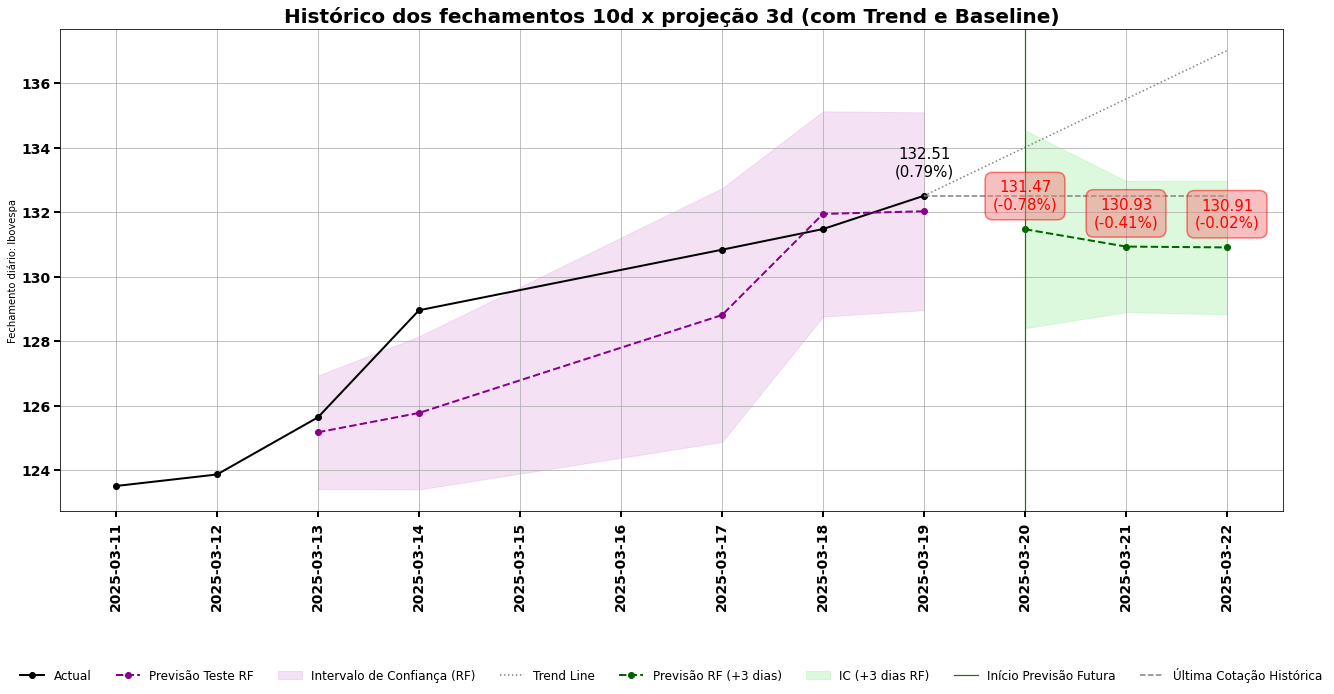

In [84]:
historic_filter = historic_pred_df.copy().tail(10)
delta_date = historic_filter[:pd.to_datetime(today-timedelta(1))]['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter[:pd.to_datetime(today-timedelta(1))])-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(20, 10))

# Plot histórico
ax.plot(historic_filter[:pd.to_datetime(today - timedelta(1))].index, 
        historic_filter[:pd.to_datetime(today - timedelta(1))]['Último'], 
        label='Actual', color='black', linewidth=2, marker='o')

# Adicionar rótulo de dados no último dia do Actual
ultimo_dia_actual = historic_filter[:pd.to_datetime(today - timedelta(1))].index[-1]
ultimo_valor_actual = historic_filter[:pd.to_datetime(today - timedelta(1))]['Último'].iloc[-1]
ultimo_var_percentual = historic_filter[:pd.to_datetime(today - timedelta(1))]['Var%'].iloc[-1]

# Texto da anotação com o valor do 'Último' e 'Var%'
texto_anotacao = f'{ultimo_valor_actual:.2f}\n({ultimo_var_percentual:.2f}%)'

# Adicionar anotação ao gráfico
ax.annotate(texto_anotacao, 
            xy=(ultimo_dia_actual, ultimo_valor_actual), 
            xytext=(0, 20),  # Deslocar o texto 20 pontos acima do ponto
            textcoords='offset points', 
            fontsize=15, color='black', ha='center')  # Centralizar horizontalmente

# Plot Previsão Random Forest
ax.plot(rf_intervalo.index, rf_intervalo['pred'], 
        label='Previsão Teste RF', color='darkmagenta', linestyle='--', linewidth=2, marker='o')

# Plot faixa de intervalo de confiança (shaded area)
ax.fill_between(rf_intervalo.index, 
                rf_intervalo['lower'], 
                rf_intervalo['upper'], 
                color='plum', alpha=0.3, label='Intervalo de Confiança (RF)')

# Linha de referência (Trend Line) - apenas a partir de today
ax.plot(historic_filter[pd.to_datetime(today-timedelta(1)):].index, 
        historic_filter[pd.to_datetime(today-timedelta(1)):]['Trend'], 
        color='gray', linestyle=':', linewidth=1.5, label='Trend Line')

# Plot Previsão Futura RF (+3 dias)
ax.plot(rf_intervalo_final.index, rf_intervalo_final['pred'], 
        label='Previsão RF (+3 dias)', color='darkgreen', linestyle='--', linewidth=2, marker='o')


# Adicionar rótulos de dados na Previsão Futura RF
for i, (data, valor) in enumerate(zip(rf_intervalo_final.index, rf_intervalo_final['pred'])):
    var_percentual = rf_intervalo_final['Var%'].iloc[i]  # Valor da coluna Var%
    texto_anotacao = f'{valor:.2f}\n({var_percentual:.2f}%)'  # Texto formatado
    
    # Definir a cor do texto e do fundo com base no valor de Var%
    if var_percentual > 0:
        cor_texto = 'darkgreen' 
        cor_fundo = 'lightgreen'  
    else:
        cor_texto = 'red' 
        cor_fundo = 'lightcoral'  
    
    # Adicionar anotação ao gráfico com caixa de fundo e 50% de transparência
    ax.annotate(texto_anotacao, 
                xy=(data, valor), 
                xytext=(0, 20),  # Deslocar o texto 20 pontos acima do ponto
                textcoords='offset points', 
                fontsize=15, color=cor_texto, ha='center',  # Cor e alinhamento do texto
                bbox=dict(boxstyle='round,pad=0.5',  # Estilo da caixa (arredondada)
                        facecolor=cor_fundo,  # Cor de fundo da caixa
                        edgecolor=cor_texto,  # Cor da borda (igual ao texto)
                        linewidth=1.5,  # Espessura da borda
                        alpha=0.5))  # 50% de transparência


# Intervalo de confiança da previsão futura
ax.fill_between(rf_intervalo_final.index, 
                rf_intervalo_final['lower'], 
                rf_intervalo_final['upper'], 
                color='lightgreen', alpha=0.3, label='IC (+3 dias RF)')

# Linha vertical separando histórico/teste da previsão futura
ax.axvline(x=rf_intervalo_final.index[0], color='green', linestyle='-', 
           linewidth=1.2, label='Início Previsão Futura')

# Linha horizontal da última cotação histórica (apenas a partir de today)
ultima_cotacao = historic_filter['Último'][:pd.to_datetime(today - timedelta(1))].iloc[-1]
ax.hlines(y=ultima_cotacao, xmin=pd.to_datetime(today-timedelta(1)), xmax=historic_filter.index[-1], 
          color='gray', linestyle='--', linewidth=1.5, label='Última Cotação Histórica')


# Formatar eixo x para mostrar dia a dia
ax.xaxis.set_major_locator(mdates.DayLocator())  # Mostrar cada dia
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato da data
plt.xticks(rotation=90)  # Rotacionar as labels do eixo x para melhor visualização

ax.tick_params(axis='x', labelsize=14, width=2, length=6, color='black')  # Aumentar tamanho e espessura
for label in ax.get_xticklabels():
    label.set_fontweight('bold')  # Deixar em negrito


ax.tick_params(axis='y', labelsize=14, width=2, length=6, color='black')  # Aumentar tamanho e espessura
for label in ax.get_yticklabels():
    label.set_fontweight('bold')  # Deixar em negrito


# Eixos
ax.set_title('Histórico dos fechamentos 10d x projeção 3d (com Trend e Baseline)', 
             fontsize=20, fontweight='bold')
ax.set_ylabel('Fechamento diário: Ibovespa')

# Estética
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=8, frameon=False, fontsize=12)
ax.grid(True)
plt.tight_layout()

# Salvar o gráfico como PNG
plt.savefig('grafico_previsao.jpeg', dpi=300, bbox_inches='tight')
plt.show()

